In [1]:
import _pickle as cPickle
import numpy as np
from scipy.io.wavfile import read
import python_speech_features as mfcc
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import time
import os
from collections import Counter
from sklearn.svm import SVC

In [2]:
source   = "development_set\\"
dest = "speaker_models\\"
train_file = "development_set_enroll_3.txt" # "train.txt" # 
n_files = 3 #training_sample

In [3]:
import numpy as np
from sklearn import preprocessing
import python_speech_features as mfcc

def calculate_delta(array):
    """Calculate and returns the delta of given feature vector matrix"""

    rows,cols = array.shape
    deltas = np.zeros((rows,20))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0:
              first =0
            else:
              first = i-j
            if i+j > rows-1:
                second = rows-1
            else:
                second = i+j 
            index.append((second,first))
            j+=1
        deltas[i] = ( array[index[0][0]]-array[index[0][1]] + (2 * (array[index[1][0]]-array[index[1][1]])) ) / 10
    return deltas

def extract_features(audio,rate):
    """on extrait 20 caracteristique de l'audio, et on calcule la variation pour augmenter le nombre de 
    caracteristique a 40"""    
    
    mfcc_feature = mfcc.mfcc(audio,rate, 0.045, 0.01,20,nfft = 2300, appendEnergy = True)    
    mfcc_feature = preprocessing.scale(mfcc_feature)
    delta = calculate_delta(mfcc_feature)
    combined = np.hstack((mfcc_feature,delta)) 
    return combined

In [4]:
count = 1
file_paths = open(train_file,'r')

label_dict = {}
y_train = []
x_train = np.asarray(())
features = np.asarray(())
avg_data = 0
training_data = 0

for i, path in enumerate(file_paths):    
    path = path.strip()   
    #print(path)
    Fs, audio = read(source + path)
    vector = extract_features(audio,Fs)
    training_data += len(audio)
    
    if features.size == 0:
        features = vector
    else:
        features = np.vstack((features, vector))
    #print(len(features))
    # when features of 5 files of speaker are concatenated, then do model training
    if count == n_files:    
        if x_train.size == 0:
            x_train = features
        else:
            x_train = np.vstack((x_train, features))
        for j in range(len(features)):
            y_train.append((i+1)//n_files)
        print()
        mn = features.shape
        print((i+1)//n_files, 'Modeled :',path.split("\\")[0], ", Training Data:", training_data/Fs, ", MFCC:", mn[1])
        label_dict[(i+1)//n_files] = path.split("\\")[0]
        features = np.asarray(())
        avg_data += training_data
        training_data = 0
        count = 0
    count = count + 1
file_paths.close()
print("Avg training_data:", avg_data/(Fs*75))


1 Modeled : sekou_1 , Training Data: 5.61922902494331 , MFCC: 40

2 Modeled : sekou_2 , Training Data: 5.828208616780046 , MFCC: 40

3 Modeled : hamadoun_1 , Training Data: 5.990748299319728 , MFCC: 40

4 Modeled : hamadoun_2 , Training Data: 5.990748299319728 , MFCC: 40

5 Modeled : djibson_1 , Training Data: 5.38702947845805 , MFCC: 40

6 Modeled : djibson_2 , Training Data: 5.224489795918367 , MFCC: 40
Avg training_data: 0.45387271352985636


In [5]:
print("Avg training_data:", avg_data/(Fs*75))

Avg training_data: 0.45387271352985636


In [6]:
label_dict

{1: 'sekou_1',
 2: 'sekou_2',
 3: 'hamadoun_1',
 4: 'hamadoun_2',
 5: 'djibson_1',
 6: 'djibson_2'}

In [7]:
len(x_train), len(x_train[0]), y_train[0], label_dict[y_train[0]]

(6754, 40, 1, 'sekou_1')

In [8]:
len(x_train), len(y_train)

(6754, 6754)

In [9]:
model = SVC(C=10,probability=True, class_weight = "balanced", decision_function_shape = 'ovo')
model.fit(x_train, y_train)

SVC(C=10, class_weight='balanced', decision_function_shape='ovo',
    probability=True)

In [10]:
picklefile = "model_5_rbf.svm"
cPickle.dump(model, open(dest + picklefile,'wb'))

# TEST

In [11]:
test_file = "development_set_test.txt"  # "test.txt" #   
file_paths = open(test_file, 'r')

svm_model = cPickle.load(open(dest + "model_5_rbf.svm",'rb'))

files  = [os.path.join(source, f[0:len(f)-1]) for f in file_paths]

In [12]:
len(files)

12

In [13]:
files[0].split("\\")[1].split("-")[0]

'sekou_1'

In [14]:
accuracy = 0
total_sample = 0
for i, path in enumerate(files):
    total_sample += 1
    Fs, audio = read(path)
    vector =   extract_features(audio,Fs)
    temp = svm_model.predict(vector)
    p=svm_model.predict_proba(vector)
    y_test = Counter(temp).most_common()[0]
    print("Taux ",np.sum(p[:,y_test[0]-1])/p.shape[0])
    if(path.split("\\")[1].split("-")[0] == label_dict[y_test[0]]):
        accuracy += 1
        print(i+1, ":", path.split("\\")[1].split("\\")[0], "Predicted as:", label_dict[y_test[0]])
    else:
        print("-----------------------------------------------")
        print(i+1, ":", path.split("\\")[1].split("\\")[0], "Predicted as:", label_dict[y_test[0]])
        print("-----------------------------------------------")
print("Accuracy =", accuracy/total_sample*100, "%")

Taux  0.7788784972117098
1 : sekou_1 Predicted as: sekou_1
Taux  0.9147642506897796
2 : sekou_2 Predicted as: sekou_2
Taux  0.8677625532906496
3 : hamadoun_1 Predicted as: hamadoun_1
Taux  0.8400135317214337
4 : hamadoun_1 Predicted as: hamadoun_1
Taux  0.8104338342866134
5 : hamadoun_1 Predicted as: hamadoun_1
Taux  0.9019923448265212
6 : hamadoun_2 Predicted as: hamadoun_2
Taux  0.8797060999003882
7 : djibson_1 Predicted as: djibson_1
Taux  0.5955071473694576
8 : djibson_2 Predicted as: djibson_2
Taux  0.3811272207279734
-----------------------------------------------
9 : test_1 Predicted as: djibson_2
-----------------------------------------------
Taux  0.3052430318878991
-----------------------------------------------
10 : test_2 Predicted as: djibson_2
-----------------------------------------------
Taux  0.280639092506822
-----------------------------------------------
11 : ibh_1 Predicted as: djibson_2
-----------------------------------------------
Taux  0.39184676777455835
--

Taux  0.8104338342866134
Predicted as: hamadoun_1


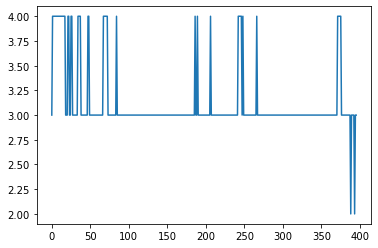

In [15]:
Fs, audio = read("development_set\\hamadoun_1\\audio6.wav")
vector =  extract_features(audio,Fs)
temp = svm_model.predict(vector)
p=svm_model.predict_proba(vector)
plt.plot(temp)
from collections import Counter 
y_test = Counter(temp).most_common()[0]
print("Taux ",np.sum(p[:,y_test[0]-1])/p.shape[0])
print("Predicted as:", label_dict[y_test[0]])

In [16]:
import pyaudio
import wave
import os
import pickle
import time
from scipy.io.wavfile import read
from IPython.display import Audio, display, clear_output

In [17]:
 #Voice authentication
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 44100
CHUNK = 1024
RECORD_SECONDS = 2

audio = pyaudio.PyAudio()

j=3
while j>=0:
    time.sleep(1.0)
    os.system('cls' if os.name == 'nt' else 'clear')
    print("Dites votre commande dans {} seconds".format(j))
    j-=1

# start Recording
stream = audio.open(format=FORMAT, channels=CHANNELS,
rate=RATE, input=True,
frames_per_buffer=CHUNK)

print("recording...")
frames = []

for _ in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

# stop Recording
stream.stop_stream()
stream.close()
audio.terminate()
        
# saving wav file of speaker
waveFile = wave.open('test.wav', 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(frames))
waveFile.close()
print("Done")
Fs, audio = read("test.wav")
vector =  extract_features(audio,Fs)
temp = svm_model.predict(vector)
p=svm_model.predict_proba(vector)
x=np.sum(p[:,y_test[0]-1])/p.shape[0]
from collections import Counter 
y_test = Counter(temp).most_common()[0]
#print("Taux ",x)
if(x>=0.20):
    result=label_dict[y_test[0]].split("_")
    print("Predicted as:",result[0] )
    if(result[1]=="1"):
        print("ouverture de la porte")
    else:
        print("validation de la seance")
else:
    print("Utilisateur non reconnu")

Dites votre commande dans 3 seconds
Dites votre commande dans 2 seconds
Dites votre commande dans 1 seconds
Dites votre commande dans 0 seconds
recording...
Done
Predicted as: hamadoun
ouverture de la porte


import math
import contextlib

fname = 'Test-2.wav'
outname = 'filtered.wav'

cutOffFrequency = 400.0

# 
def running_mean(x, windowSize):
  cumsum = np.cumsum(np.insert(x, 0, 0)) 
  return (cumsum[windowSize:] - cumsum[:-windowSize]) / windowSize

# 
def interpret_wav(raw_bytes, n_frames, n_channels, sample_width, interleaved = True):

    if sample_width == 1:
        dtype = np.uint8 # unsigned char
    elif sample_width == 2:
        dtype = np.int16 # signed 2-byte short
    else:
        raise ValueError("Only supports 8 and 16 bit audio formats.")

    channels = np.fromstring(raw_bytes, dtype=dtype)

    if interleaved:
        # channels are interleaved, i.e. sample N of channel M follows sample N of channel M-1 in raw data
        channels.shape = (n_frames, n_channels)
        channels = channels.T
    else:
        # channels are not interleaved. All samples from channel M occur before all samples from channel M-1
        channels.shape = (n_channels, n_frames)

    return channels

with contextlib.closing(wave.open(fname,'rb')) as spf:
    sampleRate = spf.getframerate()
    ampWidth = spf.getsampwidth()
    nChannels = spf.getnchannels()
    nFrames = spf.getnframes()

    # Extract Raw Audio from multi-channel Wav File
    signal = spf.readframes(nFrames*nChannels)
    spf.close()
    channels = interpret_wav(signal, nFrames, nChannels, ampWidth, True)

    # get window size
    # 
    freqRatio = (cutOffFrequency/sampleRate)
    N = int(math.sqrt(0.196196 + freqRatio**2)/freqRatio)

    # Use moviung average (only on first channel)
    filtered = running_mean(channels[0], N).astype(channels.dtype)

    wav_file = wave.open(outname, "w")
    wav_file.setparams((1, ampWidth, sampleRate, nFrames, spf.getcomptype(), spf.getcompname()))
    wav_file.writeframes(filtered.tobytes('C'))
    wav_file.close()

import malaya_speech
import numpy as np
import librosa
y, sr = malaya_speech.load('speech/podcast/nusantara.wav')
from pydub import AudioSegment
from pydub.silence import split_on_silence

y_int = malaya_speech.astype.float_to_int(y)
audio = AudioSegment(
    y_int.tobytes(),
    frame_rate = sr,
    sample_width = y_int.dtype.itemsize,
    channels = 1
)
audio_chunks = split_on_silence(
    audio,
    min_silence_len = 200,
    silence_thresh = -30,
    keep_silence = 100,
)
audio_chunks
y_ = sum(audio_chunks)
y_ = np.array(y_.get_array_of_samples())
y_ = malaya_speech.astype.int_to_float(y_)
